In [1]:
from dotenv import load_dotenv

from ipynb.income_tax_graph import graph_builder, vector_store, retriever

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str # 사용자 질문
    answer: str # 세율
    tax_base_equation: str #과세표준 계산 수식
    tax_deduction: str#공제액
    market_ratio: str #공정시장가액비율
    tax_base: str #과세표준 계산

graph_builder = StateGraph(AgentState)

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection',
)

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [4]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [5]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')


In [6]:
tax_base_retrieval_chain = (
        {'context': retriever, 'question': RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요'),
    ('human', '{tax_base_equation_information}')
])

tax_base_equation_chain = (
    {'tax_base_equation_information': RunnablePassthrough()}
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()
)

tax_base_chain = {'tax_base_equation_information': tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState):
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)

    return {'tax_base_equation': tax_base_equation}

In [7]:

#{'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제 금액) × 공정시장가액비율'}

In [8]:
tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState):
    tax_deduction_question = '주택에 대한 종합부동산세 계산시공제금액을 알려주세요'
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction': tax_deduction}

In [9]:
# get_tax_deduction({})
#{'tax_deduction': '주택에 대한 종합부동산세의 공제 금액은 1세대 1주택자는 12억 원, 법인 또는 법인으로 보는 단체는 6억 원, 그리고 그 외의 경우는 9억 원입니다.'}

In [10]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

def get_market_ratio(state: AgentState):
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇 %인가요?'
    context = tavily_search_tool.invoke(query)
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        |StrOutputParser()
    )
    tax_market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    return {'market_ratio': tax_market_ratio}

/var/folders/1c/dwy747jx7m52_6rp06qvypx40000gn/T/ipykernel_9502/3911255018.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [11]:
get_market_ratio({})
#{'market_ratio': '2025년의 주택 공시가격 공정시장가액비율은 60%입니다.'}

{'market_ratio': '2025년 주택 공시가격에 대한 공정시장가액비율은 1세대 1주택자 기준으로 80%로 예상됩니다.'}

In [12]:
from langchain_core.prompts import PromptTemplate

tax_base_cacluation_prompt = ChatPromptTemplate.from_messages([
    ('system',"""
    주어진 내용을 기반으로과세표준을 계산해주세요

    과세표준 계산 공식: {tax_base_equation}
    공제금액: {tax_deduction}
    공정시장가액비율: {market_ratio}
    사용자 주택 공시가격 정보: {query}"""),
    ('human', '사용자 주택 공시가격 정보: {query}')
])

def calculate_tax_base(state: AgentState):
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    tax_base_calculation_chain = (
        tax_base_cacluation_prompt
        | llm
        | StrOutputParser()
    )
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })
    print(f"tax_base == {tax_base}")
    return {'tax_base': tax_base}

In [13]:
initial_state = {
    'query': query,
    'tax_deduction': '주택에 대한 종합부동산세의 공제 금액은 1세대 1주택자는 12억 원, 법인 또는 법인으로 보는 단체는 6억 원, 그리고 그 외의 경우는 9억 원입니다.',
    'market_ratio': '2025년의 주택 공시가격 공정시장가액비율은 60%입니다.',
    'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제 금액) × 공정시장가액비율'
}

In [14]:
calculate_tax_base(initial_state)

tax_base == 세금을 계산하기 위해 과세표준을 먼저 계산해 봅시다.

1. 주택의 공시가격 합계: 5억 + 10억 + 20억 = 35억 원

2. 공제 금액:
   - 1세대 1주택자: 12억 원
   - 법인 또는 법인으로 보는 단체: 6억 원
   - 그 외의 경우: 9억 원

   사용자가 해당되는 경우에 따라서 적용하면 됩니다. 여기서 사용자는 1세대 1주택자가 아니라면 그 외의 경우에 해당됩니다.

3. 과세표준:
   - (주택의 공시가격 합계 - 공제 금액) × 공정시장가액비율
   - = (35억 - 9억) × 60%
   - = 26억 × 0.6
   - = 15.6억 원

최종 과세표준은 15.6억 원이 됩니다. 이 과세표준을 바탕으로 세금을 계산해야 합니다. 세율이 주어지지 않았으므로, 일반적으로 국가나 지방자치단체에서 제공하는 세율표에 따라 세금을 계산할 수 있습니다.


{'tax_base': '세금을 계산하기 위해 과세표준을 먼저 계산해 봅시다.\n\n1. 주택의 공시가격 합계: 5억 + 10억 + 20억 = 35억 원\n\n2. 공제 금액:\n   - 1세대 1주택자: 12억 원\n   - 법인 또는 법인으로 보는 단체: 6억 원\n   - 그 외의 경우: 9억 원\n\n   사용자가 해당되는 경우에 따라서 적용하면 됩니다. 여기서 사용자는 1세대 1주택자가 아니라면 그 외의 경우에 해당됩니다.\n\n3. 과세표준:\n   - (주택의 공시가격 합계 - 공제 금액) × 공정시장가액비율\n   - = (35억 - 9억) × 60%\n   - = 26억 × 0.6\n   - = 15.6억 원\n\n최종 과세표준은 15.6억 원이 됩니다. 이 과세표준을 바탕으로 세금을 계산해야 합니다. 세율이 주어지지 않았으므로, 일반적으로 국가나 지방자치단체에서 제공하는 세율표에 따라 세금을 계산할 수 있습니다.'}

In [15]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의질문에 대한 종합부동산세를 계산해주세요

    종합부동산세 세율:{context}'''),
    ('human', '''과세표준 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

    과세표준: {tax_base}
    주택 수: {query}
    ''')
])

def calculate_tax_rate(state: AgentState):
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_rate = tax_rate_chain.invoke({
        'context': context,
        'tax_base': tax_base,
        'query': query
    })
    print(f"tax_rate == {tax_rate}")
    return {'tax_rate': tax_rate}


In [16]:
calculate_tax_base(initial_state)

tax_base == 주어진 주택의 공시가격 합계는 5억 + 10억 + 20억 = 35억 원입니다.

사용자가 1세대 1주택자, 법인 또는 법인으로 보는 단체가 아닌 경우로 가정하고, 공제금액은 9억 원입니다.

과세표준을 계산해보겠습니다:
과세표준 = (35억 원 - 9억 원) × 60%
과세표준 = 26억 원 × 0.60
과세표준 = 15.6억 원

따라서, 사용자의 과세표준은 15.6억 원입니다. 종합부동산세는 과세표준에 따라 세율을 적용하여 계산되지만, 여기서는 과세표준만 계산하였습니다. 세금을 정확히 계산하려면 해당 연도의 세율 표를 참고해야 합니다.


{'tax_base': '주어진 주택의 공시가격 합계는 5억 + 10억 + 20억 = 35억 원입니다.\n\n사용자가 1세대 1주택자, 법인 또는 법인으로 보는 단체가 아닌 경우로 가정하고, 공제금액은 9억 원입니다.\n\n과세표준을 계산해보겠습니다:\n과세표준 = (35억 원 - 9억 원) × 60%\n과세표준 = 26억 원 × 0.60\n과세표준 = 15.6억 원\n\n따라서, 사용자의 과세표준은 15.6억 원입니다. 종합부동산세는 과세표준에 따라 세율을 적용하여 계산되지만, 여기서는 과세표준만 계산하였습니다. 세금을 정확히 계산하려면 해당 연도의 세율 표를 참고해야 합니다.'}

In [20]:
tax_base_state = {'tax_base': '주어진 주택의 공시가격 합계는 5억 + 10억 + 20억 = 35억 원입니다.\n\n사용자가 1세대 1주택자, 법인 또는 법인으로 보는 단체가 아닌 경우로 가정하고, 공제금액은 9억 원입니다.\n\n과세표준을 계산해보겠습니다:\n과세표준 = (35억 원 - 9억 원) × 60%\n과세표준 = 26억 원 × 0.60\n과세표준 = 15.6억 원\n\n따라서, 사용자의 과세표준은 15.6억 원입니다. 종합부동산세는 과세표준에 따라 세율을 적용하여 계산되지만, 여기서는 과세표준만 계산하였습니다. 세금을 정확히 계산하려면 해당 연도의 세율 표를 참고해야 합니다.', 'query': query}

In [21]:
calculate_tax_rate(tax_base_state)

tax_rate == 사용자가 3채의 주택을 소유하고 있으며, 총 과세표준은 이전에 계산된 대로 15.6억 원입니다. 세율은 3주택 이상을 소유한 경우의 세율을 사용해야 합니다.

- 과세표준 15.6억 원은 '12억 원 초과 25억 원 이하' 구간에 해당합니다.
- 이 구간의 세율은 기본 세액 960만 원 + 초과 금액의 1천분의 20입니다.

다음과 같이 계산합니다:

1. 기본 세액: 960만 원
2. 12억 원을 초과하는 금액: 15.6억 원 - 12억 원 = 3.6억 원
3. 초과 부분에 대한 세액: 3.6억 원 × 0.002 = 720만 원

따라서, 총 종합부동산세는 다음과 같습니다:
- 총 세액 = 기본 세액 + 초과 부분의 세액
- 총 세액 = 960만 원 + 720만 원 = 1,680만 원

따라서 사용자는 종합부동산세로 1,680만 원을 납부해야 합니다.


{'tax_rate': "사용자가 3채의 주택을 소유하고 있으며, 총 과세표준은 이전에 계산된 대로 15.6억 원입니다. 세율은 3주택 이상을 소유한 경우의 세율을 사용해야 합니다.\n\n- 과세표준 15.6억 원은 '12억 원 초과 25억 원 이하' 구간에 해당합니다.\n- 이 구간의 세율은 기본 세액 960만 원 + 초과 금액의 1천분의 20입니다.\n\n다음과 같이 계산합니다:\n\n1. 기본 세액: 960만 원\n2. 12억 원을 초과하는 금액: 15.6억 원 - 12억 원 = 3.6억 원\n3. 초과 부분에 대한 세액: 3.6억 원 × 0.002 = 720만 원\n\n따라서, 총 종합부동산세는 다음과 같습니다:\n- 총 세액 = 기본 세액 + 초과 부분의 세액\n- 총 세액 = 960만 원 + 720만 원 = 1,680만 원\n\n따라서 사용자는 종합부동산세로 1,680만 원을 납부해야 합니다."}

In [22]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)

In [23]:
from langgraph.graph import START, END
graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [24]:
graph = graph_builder.compile()

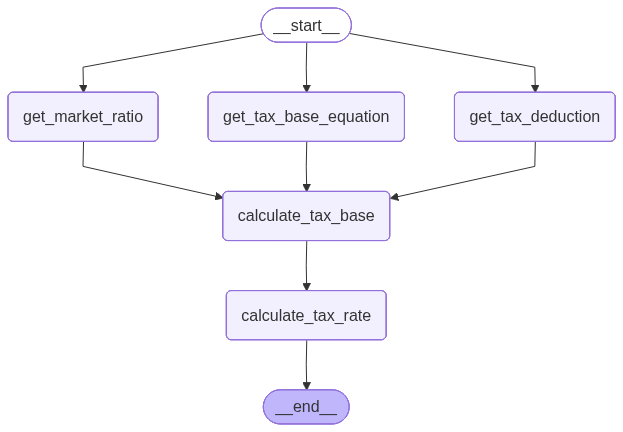

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
initial_state = {'query': query}
graph.invoke(initial_state)

tax_base == 사용자가 보유한 주택의 공시가격 총액을 계산합니다:

5억 원 + 10억 원 + 20억 원 = 35억 원

1세대 1주택자가 아닌 경우의 공제 금액은 9억 원입니다. 따라서 과세표준은 다음과 같이 계산됩니다:

과세표준 = (35억 원 - 9억 원) × 80%
과세표준 = 26억 원 × 0.8
과세표준 = 20.8억 원

따라서, 과세표준은 20.8억 원입니다. 실제로 납부해야 하는 세금은 이 과세표준을 바탕으로 세율을 적용하여 계산됩니다. 하지만 세율 정보가 주어지지 않았으므로, 세급을 계산하는 방법은 여기까지 제공할 수 있습니다.
tax_rate == 주어진 정보에 따르면 사용자는 총 3채의 주택을 보유하고 있습니다. 따라서 종합부동산세 계산 시 3주택 이상 소유한 경우의 세율을 적용해야 합니다.

계산 과정은 다음과 같습니다:

1. 공시가격 총액은 35억 원입니다.
2. 공제 금액은 9억 원입니다.
3. 과세표준은 (35억 원 - 9억 원) × 80% = 20.8억 원입니다.

다음은 3주택 이상 소유한 경우의 과세표준에 따른 종합부동산세 세율을 적용한 계산입니다:

과세표준이 12억 원 초과 25억 원 이하인 경우, 세율은 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)입니다.

4. 과세표준 20.8억 원이 12억 원을 초과한 금액: 20.8억 원 - 12억 원 = 8.8억 원
5. 세금 계산: 960만 원 + (8.8억 원 × 0.002) = 960만 원 + 1760만 원 = 2720만 원

따라서 사용자는 약 2720만 원의 종합부동산세를 납부해야 합니다.


{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'tax_base_equation': '과세표준 = (주택 공시가격 총액 - 공제 금액) × 공정시장가액비율',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시, 1세대 1주택자의 경우 공제금액은 12억 원입니다. 1세대 1주택자가 아닌 경우는 9억 원, 법인이나 법인으로 보는 단체는 6억 원을 공제받습니다.',
 'market_ratio': '2025년 주택 공시가격에 대한 공정시장가액비율은 80%로 예상됩니다.',
 'tax_base': '사용자가 보유한 주택의 공시가격 총액을 계산합니다:\n\n5억 원 + 10억 원 + 20억 원 = 35억 원\n\n1세대 1주택자가 아닌 경우의 공제 금액은 9억 원입니다. 따라서 과세표준은 다음과 같이 계산됩니다:\n\n과세표준 = (35억 원 - 9억 원) × 80%\n과세표준 = 26억 원 × 0.8\n과세표준 = 20.8억 원\n\n따라서, 과세표준은 20.8억 원입니다. 실제로 납부해야 하는 세금은 이 과세표준을 바탕으로 세율을 적용하여 계산됩니다. 하지만 세율 정보가 주어지지 않았으므로, 세급을 계산하는 방법은 여기까지 제공할 수 있습니다.'}